# WINNING JEOPARDY
Jeopardy is a popular TV show in the US where participants answer questions to win money. It's been running for a few decades, and is a major force in popular culture. Reddit kindly offers a [dataset of over 200k questions](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/) that we can use to explore in case we ever want to compete in Jeopardy. Can all this knowledge help us somehow in improving our winning odds?  

Let's take a look!

In [1]:
import pandas as pd
j = pd.read_csv('JEOPARDY_CSV.csv')
j.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [2]:
#Get details of available data types in each column. This is more complete than file.dtypes
for i in range (0,7):
    print(j.iloc[:,i].apply(type).value_counts())

<class 'int'>    216930
Name: Show Number, dtype: int64
<class 'str'>    216930
Name:  Air Date, dtype: int64
<class 'str'>    216930
Name:  Round, dtype: int64
<class 'str'>    216930
Name:  Category, dtype: int64
<class 'str'>    216930
Name:  Value, dtype: int64
<class 'str'>    216930
Name:  Question, dtype: int64
<class 'str'>      216928
<class 'float'>         2
Name:  Answer, dtype: int64


We will need as a first tas to perform some data cleaning on the dataset, for which we'll write dedicated functions:
1. column names to be renames
2. texts to be normalized  
    2.1. strip HTML  
    2.2. remove punctuation  
3. types in `Air Date` - from string to datetime
4. types in `value` to become integers

In [3]:
#1. clean columns by replacing whitespace at beginning + end of string
import re
def cleaner(string):
    string = re.sub(r"^\s+", "", string, flags=re.UNICODE)
    string = string.lower()
    return string

#apply cleaning function to each element in file.columns and return as list, then reassign
cols = [cleaner(c) for c in j.columns]
j.columns = cols

In [4]:
#2.1. Strip hml tags
#great take from https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python

from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

j["clean_question"] = j["question"].apply(strip_tags)


#2.2. define and apply cleaning function to normalize texts in columns
import string as s
def normalize(text):
    text = str(text).lower()
    text = text.translate(text.maketrans('','', s.punctuation)) #strip of all punctuation
    return text

j["clean_question"] = j["clean_question"].apply(normalize)
j["clean_answer"] = j["answer"].apply(normalize)

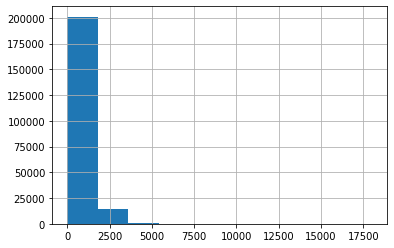

In [5]:
#3. string to datetime
j["air date"] = pd.to_datetime(j["air date"])


#4 clean values
def value_clean(arg):
    arg = arg.translate(arg.maketrans('','', s.punctuation))
    try:
        arg = int(arg)
    except:
        arg = 0
    return arg

j["clean_value"] = j["value"].apply(value_clean)
j["clean_value"].hist()

In [6]:
j.head()

,show number,air date,round,category,value,question,answer,clean_question,clean_answer,clean_value
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,200
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,200
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,200


# Studying approach

In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

1. How often the answer is deducible from the question.
2. How often new questions are repeats of older questions.  

We will try to answer question 1 by checking how many times words in the answer also occur in the question.

---
## **1. How often the answer is deducible from the question.**


In [7]:
#Generate two columns splitting into single words questions and answers
j["split_question"] = j["clean_question"].apply(lambda x: x.split())
j["split_answer"] = j["clean_answer"].apply(lambda x: x.split())


#run a quick check to identify any rows that have empty lists in split_answer
j.iloc[j["split_answer"][j["split_answer"].apply(len) == 0].index].head()

,show number,air date,round,category,value,question,answer,clean_question,clean_answer,clean_value,split_question,split_answer
36594,5555,2008-10-31,Jeopardy!,MORSE CODE,$1000,"(<a href=""http://www.j-archive.com/media/2008-...",@,kelly of the clue crew shows an animation on t...,,1000,"[kelly, of, the, clue, crew, shows, an, animat...",[]
70673,3757,2000-12-26,Jeopardy!,THIS LAND IS YOUR LAND,$300,Of the 4 presidents pictured here [rest of clu...,-----------------------------------,of the 4 presidents pictured here rest of clue...,,300,"[of, the, 4, presidents, pictured, here, rest,...",[]
90751,4204,2002-12-05,Jeopardy!,THE MUSEUM OF FLIGHT,$400,[Sarah of the Clue Crew reports from the Museu...,-----------------------------------,sarah of the clue crew reports from the museum...,,400,"[sarah, of, the, clue, crew, reports, from, th...",[]
90763,4204,2002-12-05,Jeopardy!,THE MUSEUM OF FLIGHT,$800,[Jimmy of the Clue Crew reports from the Museu...,------------------------------------,jimmy of the clue crew reports from the museum...,,800,"[jimmy, of, the, clue, crew, reports, from, th...",[]
90782,4204,2002-12-05,Double Jeopardy!,THEATER,$800,[Video clue with picture of Helen Hayes],-------------------------------------,video clue with picture of helen hayes,,800,"[video, clue, with, picture, of, helen, hayes]",[]


In [8]:
#drop no-answer rows according to their indexes
idx_to_drop = j[j["split_answer"].apply(len) == 0].index
j = j.drop(index = idx_to_drop).reset_index(drop = True)

After having cleaned the rows that were with no answer, we can try to understand how often the answer is deducible from the question.  
For each entry, we will:
- Check all the words within `split_answer` and `split_question`
- Add a cleaning layer by removing common stopwords after importing the `nltk` library
- Count how many of the words in `split_answer` are contained in `split_question`
- Calculate a goodness_index and store it into a new column named `answer_in_question`, which represents the **% of correct words in the answer** (against the total number of words in the answer).

In [9]:
'''
The following function is to be applied to a row (axis = 1) and performs the following operations:
- Strips the answer of stopwords
- Counts the number of words in the answer that appear in the question
- Calculates a goodness_index as the (total number of matching words / total words in answer)
- Returns the goodness_index
'''
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

def count_matches(row):
    match_count = 0
    answer = row["split_answer"]
    question = row["split_question"]

    #clean answer of stopwords
    for word in stop_words:
        if word in answer:
            answer.remove(word)

    #check if after clearing answer length is 0, in which case return 0
    if len(answer) == 0:
        return 0

    #as a last step, count the number of words within the answer and return the goodness_index
    try:
        for w in answer:
            if w in question:
                match_count += 1
    except:
        pass #not great - how to log/print errors while applying a function to a dataframe?
    
    goodness_index = match_count / len(answer)   
  
    return goodness_index



j["answer_in_question"] = j.apply(count_matches, axis=1)

Great - let's now plot the results to better understand how often questions already contain their answers, at least to an extent: this will give us some context and help us get a clear idea if good intuition can let us achieve results in Jeopardy.

The mean ratio of correct words in answer / total number in answer is around 3.95%


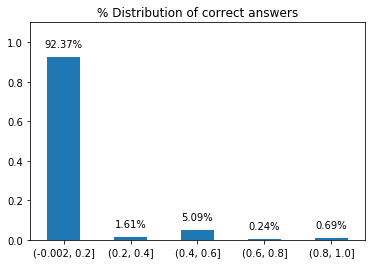

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

#generate series and plot
series = j["answer_in_question"].value_counts(normalize = True, bins = 5).sort_index()
series.plot.bar()

#prepare annotation data
labels = series.map("{:.2%}".format)

for i in range(0,len(series)):
    plt.annotate(labels.iloc[i],
                 xy = (i, series.iloc[i] + 0.05),
                 ha = 'center'
                )
    
plt.xticks(rotation = 0)
plt.title('% Distribution of correct answers')
plt.ylim(0,1.1)


score = j["answer_in_question"].mean()
print('The mean ratio of correct words in answer / total number in answer is around {:.2%}'.format(score))


It's pretty evident that **it's rare for any question to contain the answer**, with 92.37% of the questions being completely unrelated in their content from the answers.

When this happens, it's rare for the answer to be fully contained in the question - more often you have just a word, or a couple, which is not indicative of the actual answer. **The few instances (0.69%) where the answer IS in the question is for closed questions** - an overall rarity. (e.g geography question on capital cities, as we can appreciate from the following sample).

In [11]:
j[j["answer_in_question"] >= 0.6].loc[:,["category","split_question","split_answer","answer_in_question"]]

,category,split_question,split_answer,answer_in_question
266,NOT A CURRENT NATIONAL CAPITAL,"[ljubljana, bratislava, barcelona]",[barcelona],1.0
272,NOT A CURRENT NATIONAL CAPITAL,"[istanbul, ottawa, amman]",[istanbul],1.0
278,NOT A CURRENT NATIONAL CAPITAL,"[sofia, sarajevo, saigon]",[saigon],1.0
284,NOT A CURRENT NATIONAL CAPITAL,"[bucharest, bonn, bern]",[bonn],1.0
290,NOT A CURRENT NATIONAL CAPITAL,"[belize, city, guatemala, city, panama, city]","[belize, city]",1.0
...,...,...,...,...
216735,IT'S A MONARCHY,"[jordan, israel, egypt]",[jordan],1.0
216741,IT'S A MONARCHY,"[denmark, ireland, france]",[denmark],1.0
216747,IT'S A MONARCHY,"[singapore, indonesia, malaysia]",[malaysia],1.0
216753,IT'S A MONARCHY,"[bhutan, benin, botswana]",[bhutan],1.0


The above is further identified if we look at the most common words in the `split_question` column: they are rather generic and question-oriented, hence it is unlikely they are repeated in the answer itself.

Text(0.5, 1.0, 'Most common words in Jeopardy questions')

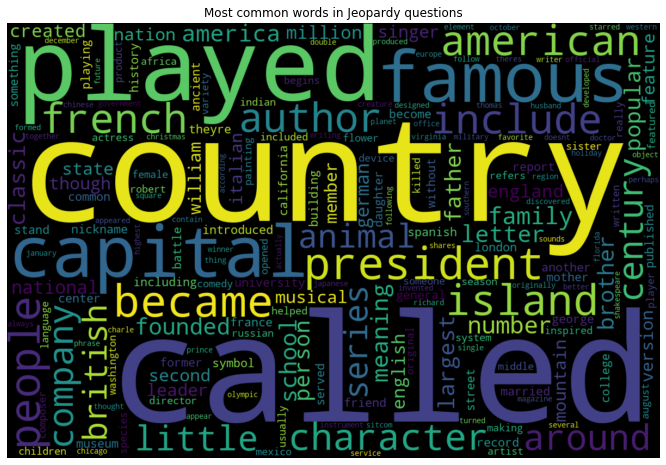

In [12]:
from wordcloud import WordCloud

all_words = []
for row in j["split_question"]:
    for word in row:
        if len(word) >= 6:
            all_words.append(word)
    #all_words.append(w)
concatenated_words = ' '.join(all_words)

wc = WordCloud(width = 1200, height = 800, stopwords = stop_words).generate(concatenated_words)

plt.figure(figsize = (12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Most common words in Jeopardy questions')

---
## **2. How often new questions are repeats of older questions?**
We are interested in understanding how often older question reappear in time. If this number is high, it will make sense for us to study in depth the older ones.
To do this, the building blocks are:

- Sort jeopardy in order of ascending air date.
- Iterate into the dataframe by creating a "master" of all the complex (>=6 characters) words used
- For each question check backwards if they were used in the past.

In [13]:
#sort dataframe in ascending order
j.sort_values("air date", ascending = True, inplace = True)

Demo a logic that per each row of the dataframe:
- accesses `split_question` column and loops into its values  
    - for each value (word) checks:
        - FIRST, if it was present in the `terms_used` set (meaning that some words of the question were already asked in the past). If yes, adds it to `recurring_words` set.
        - SECOND, if it matches our criteria (longer than 6 **and** not in stop_words). If yes, adds it to the `terms_used` set.
    - counts the number of words matching the criteria
    - prints the following info:
        - iteration count
        - In that iteration, how many words were used in the past
        - total number of words in the `terms_used` set
        - recurring words

In [14]:
terms_used = set()
recurring_words = set() #a set containing all the recurring words in questions
question_overlap = [] #list that we will throw into a dataframe column
loop_count = 0

for row in j.itertuples():
    #instantiate a variable that will reset at each loop run - it counts how many words in the question appeared in the past
    words_used_in_past_count = 0

    for word in row[11]: #row[11] is split_question column
        if word in terms_used:
            words_used_in_past_count +=1 #count how many words in the row
            recurring_words.add(word)
        if len(word) >= 6 and word not in stop_words:
            terms_used.add(word) #Enrich the tems_used set - for each row it will become longer.
            
    loop_count += 1
    print(f"In iteration {loop_count} there are {words_used_in_past_count} words used previously. | total terms in set --> {len(terms_used)}.")
    
    if len(recurring_words) == 2:
        break

#out of loop, return a full list of the recurring words
print(f"This is the list of recurring words till iteration {loop_count} --> {recurring_words}")
        

In iteration 1 there are 0 words used previously. | total terms in set --> 1.
In iteration 2 there are 0 words used previously. | total terms in set --> 4.
In iteration 3 there are 0 words used previously. | total terms in set --> 6.
In iteration 4 there are 0 words used previously. | total terms in set --> 7.
In iteration 5 there are 0 words used previously. | total terms in set --> 9.
In iteration 6 there are 0 words used previously. | total terms in set --> 14.
In iteration 7 there are 0 words used previously. | total terms in set --> 18.
In iteration 8 there are 0 words used previously. | total terms in set --> 20.
In iteration 9 there are 0 words used previously. | total terms in set --> 26.
In iteration 10 there are 0 words used previously. | total terms in set --> 28.
In iteration 11 there are 0 words used previously. | total terms in set --> 32.
In iteration 12 there are 0 words used previously. | total terms in set --> 33.
In iteration 13 there are 0 words used previously. | t

Good, it works fine. We will expand this to the whole dataframe, and at the same time for each row calculate  

**how many words in the question were used in the past / total number of words in the question**. 

This will give us a % saying basically how much of the answer was already appearing in the past.

In [15]:
#for commented code look on the cell above
terms_used = set()
recurring_words = set()
question_overlap_perc = [] #list that we will throw into a dataframe column

for row in j.itertuples():
    words_used_in_past_count = 0
    
    for word in row[11]:
        if word in terms_used:
            words_used_in_past_count +=1
            recurring_words.add(word)
        if len(word) >= 6 and word not in stop_words:
            terms_used.add(word)

    if len(row[11]) > 0:
        words_used_in_past_count /= len(row[11])

    question_overlap_perc.append(words_used_in_past_count)       


j["question_overlap"] = question_overlap_perc
j["question_overlap"].mean()

0.27727729406972673

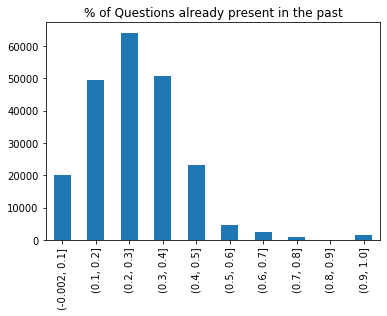

In [16]:
j["question_overlap"].value_counts(bins = 10).sort_index().plot.bar(title='% of Questions already present in the past')

By looking at our newborn column, we can say that 27.7% of the words in the question had been used in the past, which is something that we can observe also in the histograms - the highest bar stays withing the 0.2 - 0.3 bucket.  
Let's try also to understand if there has been a progression in the years - We could expect that over time the value of `question_overlap` should grow in the years, given our set of terms_used should be much much bigger. Let's group data by year and see if there is an improvement.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

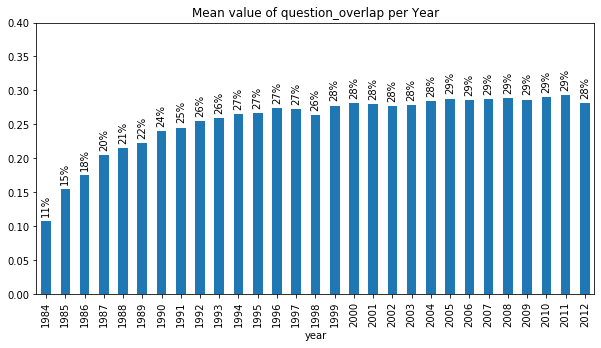

In [17]:
#Create a year only column
j["year"] = j["air date"].apply(lambda x: str(x)[:4])


#plot data
year_series = j.groupby("year")["question_overlap"].agg('mean')
year_series.plot.bar(title = 'Mean value of question_overlap per Year',
                                                           ylim = (0,0.4), 
                                                           figsize = (10,5)
                                                          )

#prepare annotation data
labels = year_series.map("{:.0%}".format)

for i in range(0,len(labels)):
    plt.annotate(labels.iloc[i],
                 xy = (i, year_series.iloc[i] + 0.01),
                 ha = 'center',
                 rotation = 90
                )
   
plt.xticks(rotation = 90)


Not that much actually! Results cap around 29%.  
We could potentially investigate more about which words appear the most - lest not forget that we have used a rather simplicistic method to consider words (it was >= 6 characters) - to understand if this number is reliable or if we have an abundance of conjunction, adverbs etc (in the print statement above we found for instance the word *'according'*).  
Nevertheless, taking a look at previous years questions would not hurt - we could narrow down the scope by looking only at high value questions.

---
# **Investigating relationships between Questions and Value**

To understand if there is a relationship between questions and their value, we can use a Chi-Squared test, which is generically used to investigate if there is a relationship between **categorical variables**.
Our categorical variables will be the **UNIQUE WORDS** in questions and their **associated value** (HIGH/LOW)
- Flag questions as high / low value (based on a 800$ threshold).
- For each question, find out how many of the words appear in terms_used, and count them.

The final result would be a count dataframe, built like the following one:

In [18]:
template = {'word': ['word_1','word_2','word_3'], 'high_value': [10,2,3], 'low_value': [1,4,2]}
sample = pd.DataFrame(data = template)
sample

,word,high_value,low_value
0,word_1,10,1
1,word_2,2,4
2,word_3,3,2


In [19]:
#flag questions
j["value_cat"] = j["clean_value"].apply(lambda x: 'High value' if x > 800 else 'Low value')
j["value_cat"].value_counts(normalize=True)

Low value     0.716844
High value    0.283156
Name: value_cat, dtype: float64

In [20]:
#prepare two dictionaries storing words and counts as key - value pairs.
dict_high = {}
dict_low = {}

for row in j.itertuples():
   
    for word in row[11]:    #for word in row[11], split_question
        if row[-1] == 'High value': #last column, value_cat
            if word in terms_used:
                if word not in dict_high.keys(): #verify if the word is already in the dictionary or not - if not, instantiate it.
                    dict_high[word] = 1
                else:
                    dict_high[word] += 1
        else: #that is, if value_cat is "Low value"
            if word in terms_used:
                if word not in dict_low.keys():
                    dict_low[word] = 1
                else:
                    dict_low[word] += 1

                
#create two dataframes from the dictionaries
high = pd.DataFrame.from_dict(dict_high, orient='index', columns = ['high_count'])
high.reset_index(inplace = True)
high.rename(columns = {"index" : 'word'}, inplace = True)

low = pd.DataFrame.from_dict(dict_low, orient='index', columns = ['low_count'])
low.reset_index(inplace = True)
low.rename(columns = {"index" : 'word'}, inplace = True)

In [21]:
#merge dataframes
chi_df = pd.merge(how = 'outer', left = high,right = low, on = 'word')
chi_df = chi_df.fillna(0)

#Coefficients for expected values in the distribution
#Low value     0.716844
#High value    0.283156  
    
chi_df["total_obs"] = chi_df.iloc[:,[1,2]].sum(axis=1)
chi_df["high_exp"] = chi_df["total_obs"] * (1-0.716844)
chi_df["low_exp"] = chi_df["total_obs"] * 0.716844

chi_df

,word,high_count,low_count,total_obs,high_exp,low_exp
0,4letter,92.0,203.0,295.0,83.531020,211.468980
1,spangled,3.0,3.0,6.0,1.698936,4.301064
2,banner,20.0,51.0,71.0,20.104076,50.895924
3,according,113.0,461.0,574.0,162.531544,411.468456
4,timothy,13.0,27.0,40.0,11.326240,28.673760
...,...,...,...,...,...,...
84215,lagrange,0.0,1.0,1.0,0.283156,0.716844
84216,standardizing,0.0,1.0,1.0,0.283156,0.716844
84217,ingenhousz,0.0,1.0,1.0,0.283156,0.716844
84218,lookinland,0.0,1.0,1.0,0.283156,0.716844


We are now in the condition of calculating chi-squared values and the related p-values.  
We are doing this to **investigate if there are some words in the answer who tend to be more related to high_value questions rather than to low_values ones** - that is, a relationship between categorical variables.

In [22]:
from scipy.stats import chisquare
import numpy as np
#create arrays structured as observed = [[array of high],[array of lows]].
obs = np.array((chi_df["high_count"], chi_df["low_count"]))
exp = np.array((chi_df["high_exp"], chi_df["low_exp"]))

#calculate calculate chisquare values  
chi_df["chi_sq"] = chisquare(obs,exp)[0]
chi_df["p_value"] = chisquare(obs,exp)[1]


#write a mask to make sure we are calculating chi_squared values on reasonable samples
mask = (chi_df["low_count"] >= 10) & (chi_df["high_count"] >= 10)
chi_df[mask].sort_values(by = "chi_sq", ascending = False).head(5)

,word,high_count,low_count,total_obs,high_exp,low_exp,chi_sq,p_value
8803,monitor,300.0,199.0,499.0,141.294844,357.705156,248.674414,5.051639e-56
7742,reports,559.0,711.0,1270.0,359.608120,910.391880,154.227135,2.065813e-35
523,french,943.0,1547.0,2490.0,705.058440,1784.941560,112.018780,3.539416e-26
14669,cheryl,294.0,350.0,644.0,182.352464,461.647536,95.359067,1.588035e-22
162,italian,423.0,581.0,1004.0,284.288624,719.711376,94.414788,2.558735e-22


Text(0.5, 1.0, 'Chi-squared distribution for high and low value questions \n (Plot only on words with count >=10)')

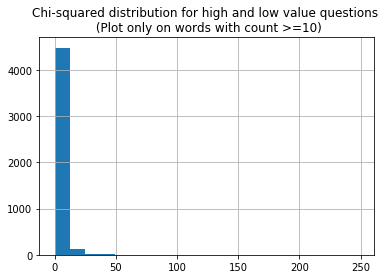

In [23]:
chi_df[mask]["chi_sq"].hist(bins=20)
plt.title("Chi-squared distribution for high and low value questions \n (Plot only on words with count >=10)")

The Chi-Squared test shows some results, yet they are extremely skewed to the right. This is a combination of multiple events, namely:
- **Huge sample size** can be a problem in the interpretation of p-values, as stated in [this paper by INFORM](https://pdfs.semanticscholar.org/262b/854628d8e2b073816935d82b5095e1703977.pdf/).

*There are many advantages to large samples, but researchers
using statistical inference must be aware of the p-value problem associated with them. In very large samples,
p-values go quickly to zero, and solely relying on p-values can lead the researcher to claim support for results of
no practical significance.*  

- **Unitary words**: single words can appear in a wide variety of questions, often unrelated one from the other. This muzzles our results badly and makes it complex to identify valid words that can be predictive of the question itself.


---
This is further enticed by checking the WordCloud generated by using the `dict_high` variable: the single keywords present in the high_value questions are still super generic and give us hard time in identifying truly valid options to narrow down our area of study. We could study generic information related to:
- countries
- presidents
- capitals
- french history? 

Jokes aside, to improve our chances of finding some relationship in the data, we should investigate set of words inside a sentence rather than individual keywords, but will leave this aside for a future project.

Text(0.5, 1.0, 'Word cloud for high-value questions')

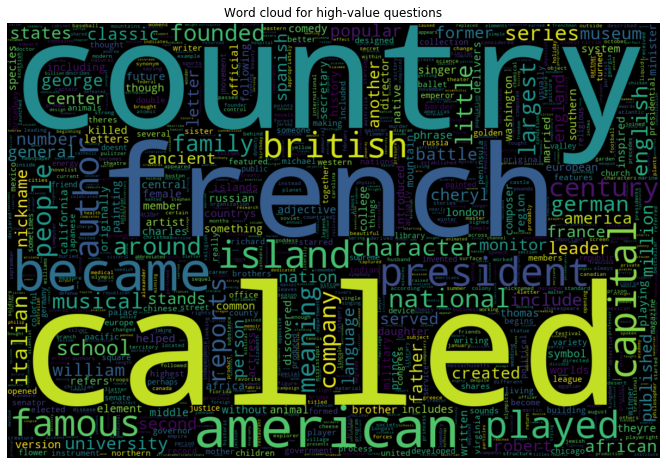

In [24]:
wc_2 = WordCloud(width = 1200, height = 800, stopwords = stop_words, max_words=1000)
   # generate word cloud
wc_2.generate_from_frequencies(dict_high)

plt.figure(figsize = (12,8))
plt.imshow(wc_2, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud for high-value questions")